# A Iterative workflow model
Here we are attempting to create a iterative workflow model using a LLM. Attempting creation of a tweet generation and review system. We also include the tweet history

## 1. Import dependencies

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama.chat_models import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
import operator

In [2]:
import nest_asyncio
nest_asyncio.apply()
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image

## 2. Linking the model

In [3]:
# generator_model = ChatOllama(model="gemma:2b")
# evaluator_model = ChatOllama(model="gemma:2b")
# optimizer_model = ChatOllama(model="gemma:2b")

generator_model = ChatOllama(model="llama3.1:8b")
evaluator_model = ChatOllama(model="llama3.1:8b")
optimizer_model = ChatOllama(model="llama3.1:8b")

## 3. Create a state

In [4]:
class TweetState(TypedDict):                      # The TweetState inherits a TypedDict
    topic           : str
    tweet           : str
    approved        : bool
    feedback        : str
    iter            : int
    max_iter        : int
    tweet_history   : Annotated[list[str], operator.add]                # Whenever creating lists, use this format, so that the contents can be appended.
    review_history  : Annotated[list[str], operator.add]

## 4. Structure for getting output from evaluator LLM

In [5]:
class tweet_evaluation(BaseModel):
    feedback : str = Field(description="The feedback about the tweet")
    approved : bool = Field("Whether the tweet has been approved for upload")

#structured_tweet_evaluator = evaluator_model.with_structured_output(tweet_evaluation)

## 5. Define the function for the graph node

In [6]:
# Here instead of returning the entire state, we are returning partial updates in the form of dictionary items of the altered values only

def generate_tweet(state: TweetState) -> TweetState:
    messages = [
            SystemMessage(content="You are a funny and clever Twitter/X influencer."),
            HumanMessage(content=f"""
                                    Write a short, original, and hilarious tweet on the topic: "{state['topic']}".
                                        Rules:
                                            - Do NOT use question-answer format.
                                            - Max 280 characters.
                                            - Use observational humor, irony, sarcasm, or cultural references.
                                            - Think in meme logic, punchlines, or relatable takes.
                                            - Use simple, day to day english
                                    """)
        ]
    output = generator_model.invoke(messages).content
    return {"tweet" : output, "tweet_history": [output]}

In [7]:
def evaluate_tweet(state: TweetState) -> TweetState:
    messages = [
            SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
            HumanMessage(content=f"""
                                    Evaluate the following tweet:

                                    Tweet: "{state['tweet']}"

                                    Use the criteria below to evaluate the tweet:

                                    1. Originality – Is this fresh, or have you seen it a hundred times before?  
                                    2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
                                    3. Punchiness – Is it short, sharp, and scroll-stopping?  
                                    4. Virality Potential – Would people retweet or share it?  
                                    5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

                                    Auto-reject if:
                                    - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
                                    - It exceeds 280 characters
                                    - It reads like a traditional setup-punchline joke
                                    - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

                                    ### Respond ONLY in structured format:
                                    - feedback: One paragraph explaining the strengths and weaknesses
                                    - approved: "approved" or "needs_improvement"
                            """)
        ]
    output = evaluator_model.with_structured_output(tweet_evaluation).invoke(messages)
    return {"feedback" : output.feedback, "review_history" : [output.feedback], "approved" : output.approved}


In [8]:
def optimize_tweet(state: TweetState) -> TweetState:
    messages = [
            SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
            HumanMessage(content=f"""
                                        Improve the tweet based on this feedback:
                                        "{state['feedback']}"

                                        Topic: "{state['topic']}"
                                        Original Tweet:
                                        {state['tweet']}

                                        Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
                                    """)
        ]
    output = optimizer_model.invoke(messages).content
    iteration = state["iter"] + 1

    return {"tweet" : output, "iter" : iteration, "tweet_history": [output]}

## 6. Define the conditional function

In [9]:
def on_review(state: TweetState) -> Literal["approved" , "not_approved"]:
    if state["approved"] == True or state["iter"] == state["max_iter"]:
        return "approved"
    else:
        return "not_approved"

## 7. Create the graph

In [10]:
# Declare the graph:
graph = StateGraph(TweetState)                    # The StateGraph takes the state as a parameter, signifying that the "state" will be exchanged between the nodes through the edges.

# Add a nodes/states to the graph:
graph.add_node("generate", generate_tweet)
graph.add_node("evaluate", evaluate_tweet)
graph.add_node("optimize", optimize_tweet)

# Add the sequential edges:
graph.add_edge(START, "generate")
graph.add_edge("generate", "evaluate")

# Add the looping edge:
graph.add_edge("optimize", "evaluate")

# Add the conditional edges:
graph.add_conditional_edges("evaluate", on_review, {"approved" : END, "not_approved": "optimize"})

## 8. Compile the graph

In [11]:
workflow = graph.compile()

## 9. The Graph

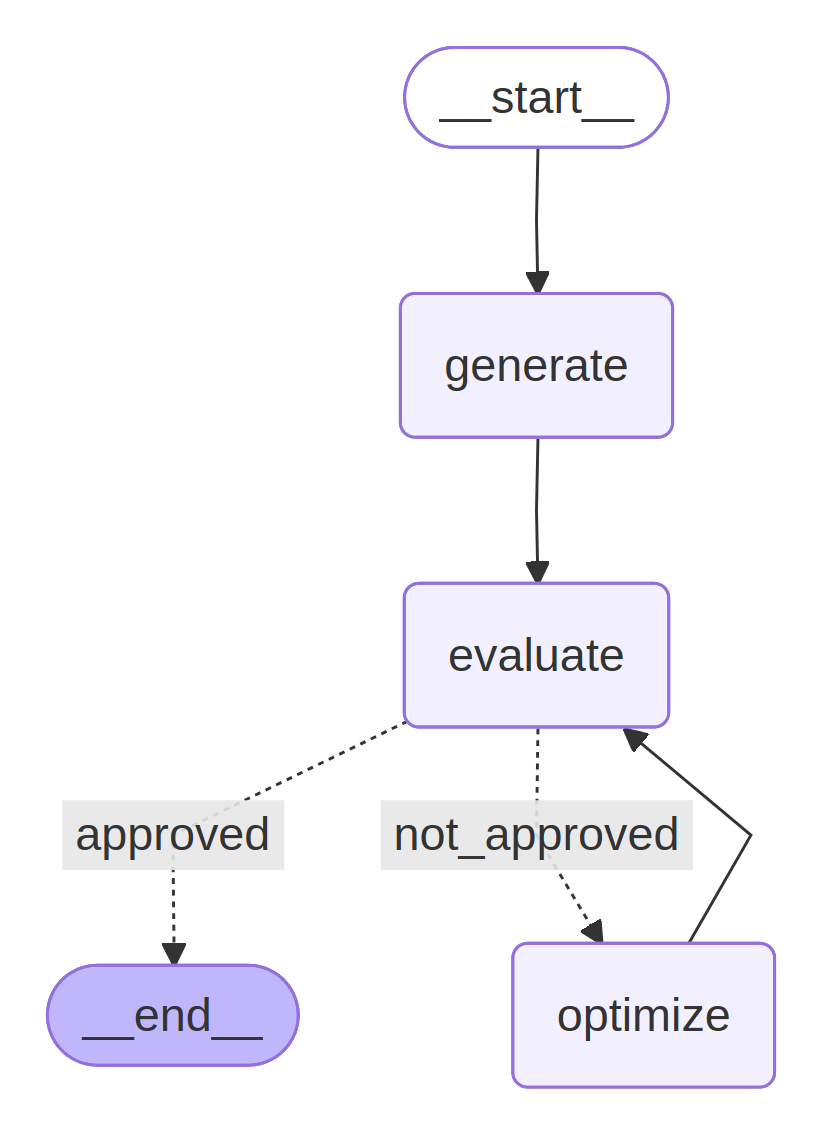

In [12]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER))

## 10. Run the code

In [13]:
topic_1 = """ Motorcycles vs Cars"""

In [14]:
initial_state = {"topic": topic_1, "max_iter" : 5, "iter" : 0}
final_state = workflow.invoke(initial_state)
print(final_state)

{'topic': ' Motorcycles vs Cars', 'tweet': 'Here\'s a revised version with a punchier delivery:\n\n"Motorcycles: freedom in every gear, financial heartbreak in every repair bill #MotorcycleLife #CarEnvy"\n\nI\'ve kept the core concept of comparing motorcycle ownership to dating, but added a fresh twist by emphasizing the financial burden of repairs. The wordplay on "financial heartbreak" aims to be more unexpected and memorable, with a dash of humor.', 'approved': False, 'feedback': "This revised tweet has improved slightly, but it still relies on familiar comparisons and wordplay. The addition of 'financial heartbreak' is a decent twist, but it's not enough to elevate the humor beyond being mildly amusing. The tone comes across as slightly self-aware, which might make some people chuckle, but it won't resonate with others. The format is well-contained within 280 characters and avoids question-answer or traditional joke structures.", 'iter': 5, 'max_iter': 5, 'tweet_history': ['"Motorc

In [15]:
print(final_state['tweet'])

Here's a revised version with a punchier delivery:

"Motorcycles: freedom in every gear, financial heartbreak in every repair bill #MotorcycleLife #CarEnvy"

I've kept the core concept of comparing motorcycle ownership to dating, but added a fresh twist by emphasizing the financial burden of repairs. The wordplay on "financial heartbreak" aims to be more unexpected and memorable, with a dash of humor.
